In [1]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import random
import numpy as np
import pylab
import quandl
quandl.ApiConfig.api_key = "32peB6ExRM7Lihbpsdsd"
import seaborn as sns
sns.set()
%matplotlib inline
#textblob to apply sentiment analysis 
from textblob import TextBlob
import preprocessor as p

# Getting Stocks

/Users/neutrino/Library/Python/3.7/lib/python/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


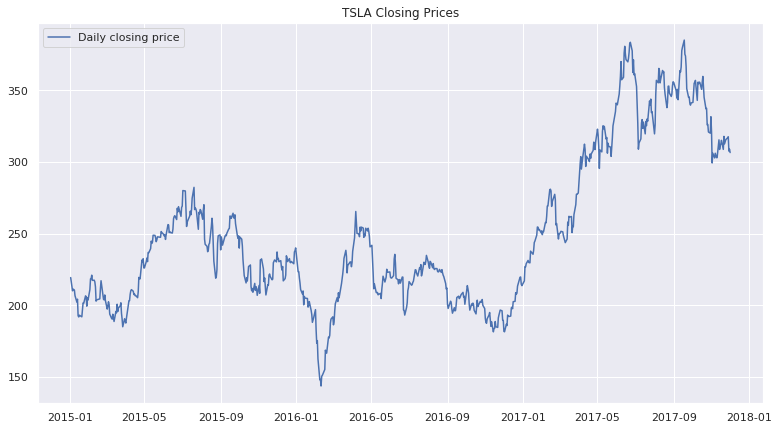

In [2]:
from pandas.plotting import register_matplotlib_converters
start = datetime.datetime(2015,1,1) # Beginning of period 
end = datetime.datetime(2017,12,1) # End of period 
stock = "TSLA" # some stock label we are interested in
data = quandl.get("WIKI/" + stock, start_date=start, end_date=end)
pylab.rcParams['figure.figsize'] = (13, 7)
plt.title(stock + " Closing Prices")
plt.plot(data["Close"],label="Daily closing price") # plot daily closing prices 
plt.legend()
plt.show()

In [3]:
data['Date'] = data.index
new_data = pd.DataFrame(index=range(0,len(data)),columns=['Date', 'Close'])
for i in range(0,len(data)):
     new_data['Date'][i] = data['Date'][i]
     new_data['Close'][i] = data['Close'][i]

      
#setting index
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)    

In [4]:
new_data.tail()

,Close
Date,
2017-11-27,316.81
2017-11-28,317.55
2017-11-29,307.54
2017-11-30,308.85
2017-12-01,306.53


# Predicting stock developtment using LSTM (Long Short Term Memory)

In [5]:
#importing required libraries
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

#splitting into train and validation
#creating train and test sets
dataset = new_data.values

train = dataset[0:500]#using the first 500 days as a train set
valid = dataset[500:]


Using TensorFlow backend.


In [6]:
print(train)

[[219.31]
 [210.09]
 [211.28]
 [210.95]
 [210.615]
 [206.66]
 [202.21]
 [204.25]
 [192.69]
 [191.87]
 [193.07]
 [191.93]
 [196.57]
 [201.62]
 [201.29]
 [206.55]
 [205.98]
 [199.37]
 [205.2]
 [203.6]
 [210.94]
 [218.36]
 [218.55]
 [220.99]
 [217.36]
 [217.48]
 [216.29]
 [212.8]
 [202.88]
 [203.77]
 [204.35]
 [204.46]
 [211.705]
 [217.11]
 [207.335]
 [204.11]
 [203.76]
 [207.19]
 [203.34]
 [197.325]
 [199.56]
 [202.435]
 [200.63]
 [193.88]
 [190.88]
 [190.32]
 [193.74]
 [191.07]
 [188.68]
 [195.7]
 [194.73]
 [200.71]
 [195.65]
 [198.08]
 [199.63]
 [201.72]
 [194.3]
 [190.405]
 [185.0]
 [190.57]
 [188.77]
 [187.59]
 [191.0]
 [203.1]
 [203.25]
 [207.67]
 [210.09]
 [210.9]
 [209.78]
 [207.46]
 [207.83]
 [206.7]
 [206.79]
 [205.27]
 [209.41]
 [219.44]
 [218.6]
 [218.425]
 [231.55]
 [230.48]
 [232.45]
 [226.05]
 [226.03]
 [230.51]
 [232.95]
 [230.43]
 [236.8]
 [236.61]
 [239.49]
 [244.74]
 [243.18]
 [244.1]
 [248.84]
 [248.75]
 [247.14]
 [244.35]
 [245.62]
 [247.73]
 [247.455]
 [247.43]
 [251

In [7]:
#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

/Users/neutrino/Library/Python/3.7/lib/python/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [8]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/1
 - 36s - loss: 0.0033


In [9]:
#predicting values, using past 60 from the train data
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

## Results

In [10]:
rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
rms

14.348797870512398

In [21]:
X_test.shape

(235, 60, 1)

/Users/neutrino/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


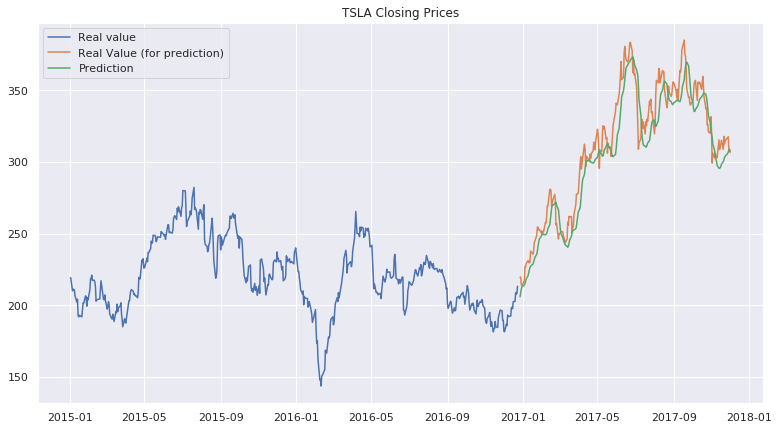

In [20]:
train = new_data[:500]
valid = new_data[500:]
valid['Predictions'] = closing_price
plt.plot(train['Close'], label = "Real value");
plt.plot(valid['Close'],label='Real Value (for prediction)');
plt.plot(valid['Predictions'],label="Prediction");
plt.title(stock + " Closing Prices")
plt.legend()

In [13]:
error_difference = pd.DataFrame(index=range(0,len(valid['Predictions'])),columns=['Close','Predictions','Error'])
for i in range(0,len(valid['Predictions'])):
     error_difference['Close'][i] = valid['Close'][i]
     error_difference['Predictions'][i] = valid['Predictions'][i]
     error_difference['Error'][i] = 100*abs(valid['Close'][i]-valid['Predictions'][i])/valid['Close'][i]


In [14]:
error_list = []
for index in range(0,len(error_difference)):
    error_list.append(error_difference['Error'][index])

3.7305918266434133 2.5303660250595


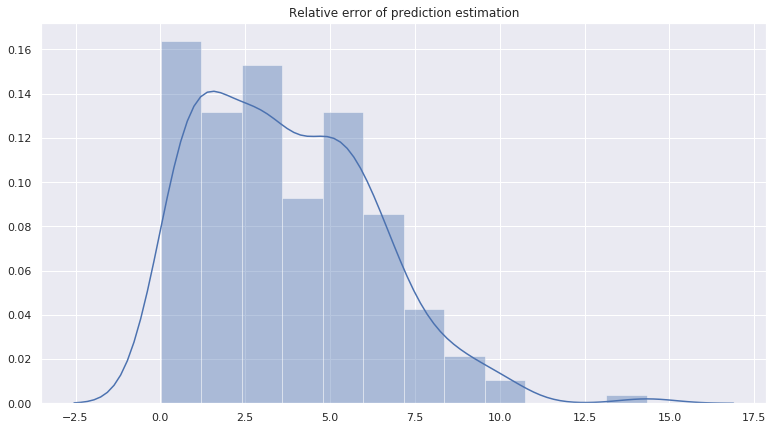

In [15]:
error_list=np.array(error_list)
sns.distplot(error_list, kde=True).set_title('Relative error of prediction estimation')
mean = error_list.mean()

rms=np.sqrt(np.mean(np.power((error_list-mean),2)))
print(mean,rms)